<h1><center>Train Model</center></h1>

In this tutorial we check the simplest way of running a model training inside the Carol Platform. This notebook fetches data from Carol, train a regression model and deploys the model to a REST API.

## 0. Installing required packages

Appart from the well known pandas an numpy libraries we are going to use:
 - sklearn: popular machine learning library comprising datasets, preprocessing and machine learning models.
 - pycarol: TOTVS library developed to assist on the data management for Carol platform.
 
I you have not yet installed these libraries just uncomment and run the cells below.

In [2]:
#!pip install pycarol
#!pip install sklearn

## 1. Fetching data from Carol

We start by defining a connection to the carol platform. To make the connection, though, we need to setup the security authorization to the environment, which is made through the __access token__.

On this example we are simply passing the credentials directly through the code, which is not the best approach for long term solution, specially if this code needs to go through version control servers. A better solution is to store these credentials in expernal files, preferably encrypted, and load them at run time.

In [6]:
from pycarol import Carol, Staging, ApiKeyAuth, Storage

login = Carol()

Now we use the authentication to fetch the data from the staging

In [13]:
staging = Staging(login)

conn = "boston_house_price"
stag = "samples"

X_cols = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"] 
y_col = ["target"]
roi_cols = X_cols + y_col

data = staging.fetch_parquet(staging_name=stag,
                connector_name=conn,
                cds=True,
                columns=roi_cols            
                )

100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Revising some sample records:

In [20]:
data.sample(3)

,AGE,B,CHAS,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX,ZN,target
550,88.8,306.38,0.0,0.95577,4.4534,8.14,17.28,0.538,21.0,4.0,6.047,307.0,0.0,14.8
622,97.4,363.43,0.0,1.22358,1.8773,19.58,4.59,0.605,14.7,5.0,6.943,403.0,0.0,41.3
27,39.0,390.50,0.0,0.09378,5.4509,7.87,15.71,0.524,15.2,5.0,5.889,311.0,12.5,21.7


## 2. Training a model

Spliting the dataset in training and test parts.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[X_cols],
                                                    data[y_col], 
                                                    test_size=0.20, 
                                                    random_state=1)

Fitting a Multilayer Perceptron model to the train data:

In [80]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train["target"].values)

Running predictions on the test set.

In [23]:
y_pred = mlp_model.predict(X_test)

## 3. Running basic evaluation

Measuring classical consilidated error metrics:

In [57]:
import numpy as np

y_real = list(y_test["target"].values)
residual = list(y_test["target"].values) - y_pred

mse_f = np.mean(residual**2)
mae_f = np.mean(abs(residual))
rmse_f = np.sqrt(mse_f)

display(f"Mean Squared Error (MSE): {mse_f}.")
display(f"Mean Absolute Error (MAE): {mae_f}.")
display(f"Root Mean Squared Error (RMSE): {rmse_f}.")

'Mean Squared Error (MSE): 32.83513021826763.'

'Mean Absolute Error (MAE): 4.538316218898927.'

'Root Mean Squared Error (RMSE): 5.7301946056192214.'

Plotting residuals

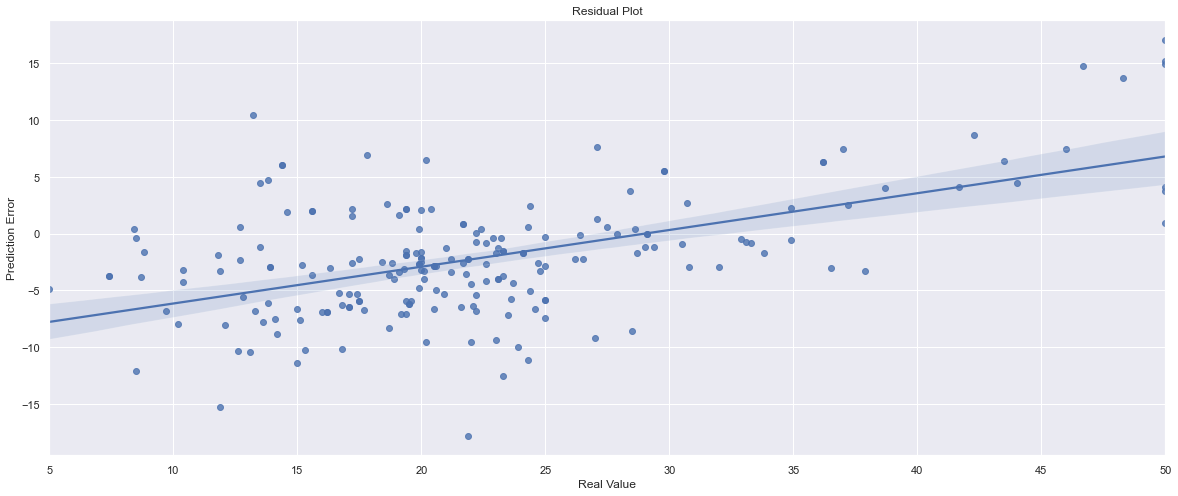

In [81]:
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)
from matplotlib import pyplot as plt

res_df = pd.DataFrame({"y":y_real, "res":residual})

plt.figure(figsize=(20,8))
ax = sns.regplot(x="y", y="res", data=res_df)
ax.set_title('Residual Plot')
tmp = ax.set(xlabel='Real Value', ylabel='Prediction Error')

## 4. Saving model to storage

In [ ]:
stg = Storage(login)
stg.save("bhp_mlp_regressor", mlp_model, format='pickle')